In [2]:
from tqdm import tqdm
from analysis.nlp_transformations import separate_previous_conversation, remove_footers
from typing import List
from dao.lab_report import DAOLabReport

from dao.attribute import DAOAttributePL

from models.attribute import AttributePL, AttributePLInDB

from ml.model_training import evaluate_models, k_fold_cross_validation
from ml.data_preparation import convert_db_attributes_to_input_data
from typing import List
from analysis.nlp_transformations import replace_links_with_text
from ml.data_preparation import find_significant_features

[nltk_data] Downloading package stopwords to /home/pawel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/pawel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package pl196x to /home/pawel/nltk_data...
[nltk_data]   Package pl196x is already up-to-date!
[nltk_data] Downloading package wordnet to /home/pawel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
dao_lab_reports: DAOLabReport = DAOLabReport()

dao_attribute: DAOAttributePL = DAOAttributePL()


generated: List[AttributePLInDB] = dao_attribute.find_many_by_query({"is_generated": True})
real: List[AttributePLInDB] = dao_attribute.find_many_by_query({"is_generated": False})

generated_flat_dict = [(x.to_flat_dict_normalized(exclude=['stylometrix_metrics']), 1) for x in generated]
real_flat_dict = [(x.to_flat_dict_normalized(exclude=['stylometrix_metrics']), 0) for x in real]

In [4]:
data = [(x.to_flat_dict_normalized(exclude=['stylometrix_metrics']), 1) for x in generated]
data += [(x.to_flat_dict_normalized(exclude=['stylometrix_metrics']), 0) for x in real]
# replace None with 0
for i in range(len(data)):
    for key in data[i][0].keys():
        if data[i][0][key] is None:
            data[i][0][key] = 0

significant_features = find_significant_features(data)

In [5]:
significant_features

['number_of_errors',
 'text_errors_by_category.TYPOGRAPHY',
 'text_errors_by_category.TYPOS',
 'average_sentence_word_length',
 'variance_sentence_char_length',
 'standard_deviation_sentence_char_length',
 'average_sentence_char_length',
 'variance_sentence_word_length',
 'standard_deviation_sentence_word_length',
 'average_word_char_length',
 'variance_word_char_length',
 'standard_deviation_word_char_length',
 'punctuation_per_sentence',
 'no_space_after_punctuation',
 'punctuation_density',
 'text_errors_by_category.PUNCTUATION',
 'double_spaces',
 'text_errors_by_category.SPELLING',
 'burstiness2',
 'question_marks',
 'emojis',
 'text_errors_by_category.MISC',
 'text_errors_by_category.CASING',
 'text_errors_by_category.SYNTAX',
 'text_errors_by_category.STYLE',
 'number_of_sentences',
 'text_errors_by_category.GRAMMAR',
 'text_errors_by_category.NUMBERS',
 'text_errors_by_category.COMPOUNDING',
 'double_exclamation_marks',
 'number_of_characters',
 'exclamation_marks',
 'text_erro

In [18]:
from matplotlib import pyplot as plt
import numpy as np


def hist_attribute(data, title, num_bin = 21, max_value=5, min_value=0, metric_name="Metric", top=0.4, file_name=""):
    data_to_plot = []
    for d in data:
        if d<max_value:
            data_to_plot.append(d)
        else:
            data_to_plot.append(max_value)

    w = (max_value-min_value)/num_bin
    weights = np.ones_like(data_to_plot) / len(data_to_plot)
    plt.hist(data_to_plot, bins=np.arange(min_value, max_value + w, w), weights=weights)
    plt.title(title)
    plt.xlim([min_value, max_value])
    plt.ylim(top=top)
    plt.xlabel(f'{metric_name} value')
    plt.ylabel('Lab reports share')
    # plt.xticks([i for i in range(min_value, max_value+1, 2)])
    plt.savefig(f'../images/{file_name}.png')
    plt.show()
    
def compare_2_hists(attribute_name: str, min_value=None, max_value=None, top=0.41, num_bin = 21):
    data_gen = [attribute[0][attribute_name] for attribute in generated_flat_dict]
    data_real = [attribute[0][attribute_name] for attribute in real_flat_dict]
    if min_value is None:
        min_value = min(min(data_gen), min(data_real))
    if max_value is None:
        max_value = max(max(data_gen), max(data_real))
    
    hist_attribute(data_gen, f'Generated lab reports', min_value=min_value, max_value=max_value, metric_name=attribute_name, top=top, num_bin=num_bin, file_name=f"{attribute_name}_gen")
    hist_attribute(data_real, f'Real lab reports', min_value=min_value, max_value=max_value, metric_name=attribute_name, top=top, num_bin=num_bin, file_name=f"{attribute_name}_rel")

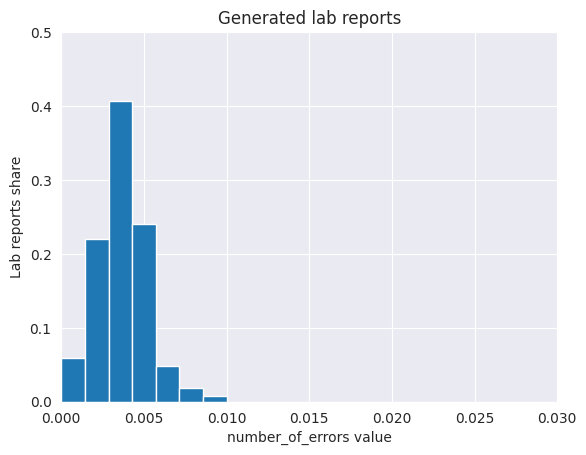

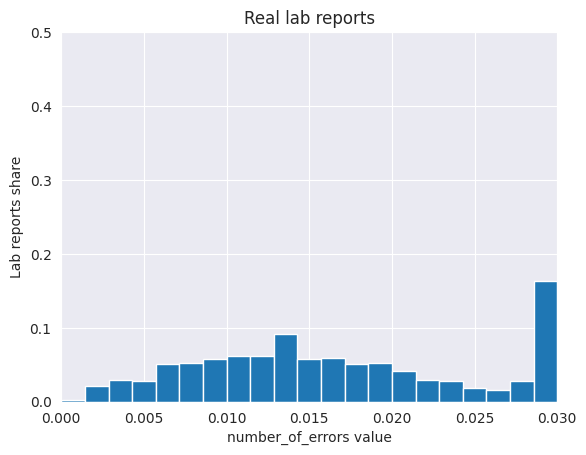

In [19]:
compare_2_hists('number_of_errors', min_value=0, max_value=0.03, top=0.5)

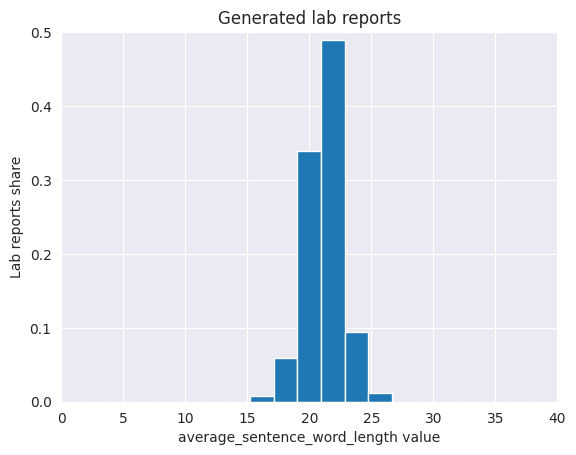

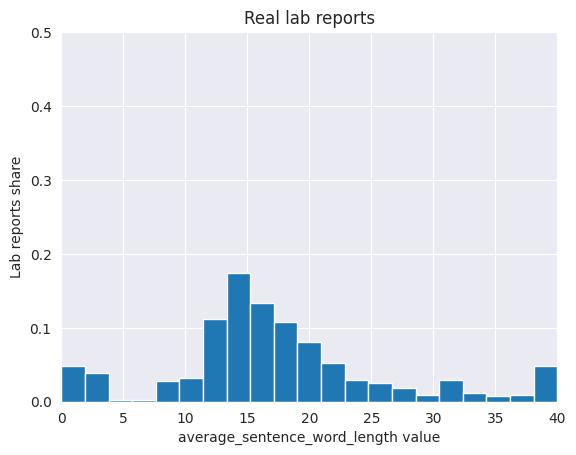

In [22]:
compare_2_hists('average_sentence_word_length', min_value=0, max_value=40, top=0.5)

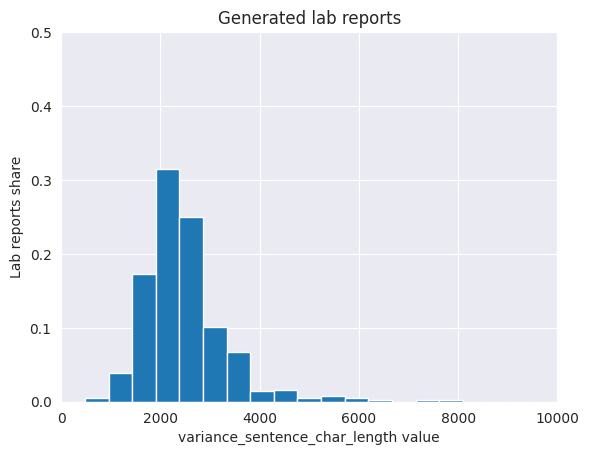

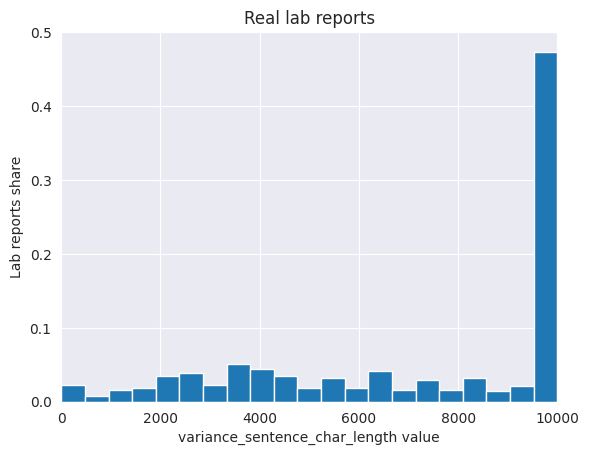

In [28]:
compare_2_hists('variance_sentence_char_length', min_value=0, max_value=10000, top=0.5)

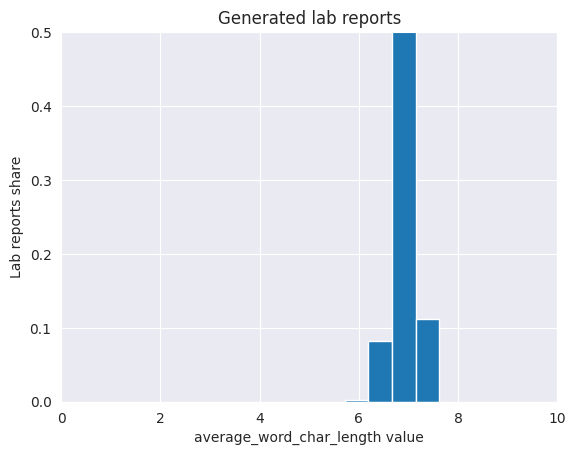

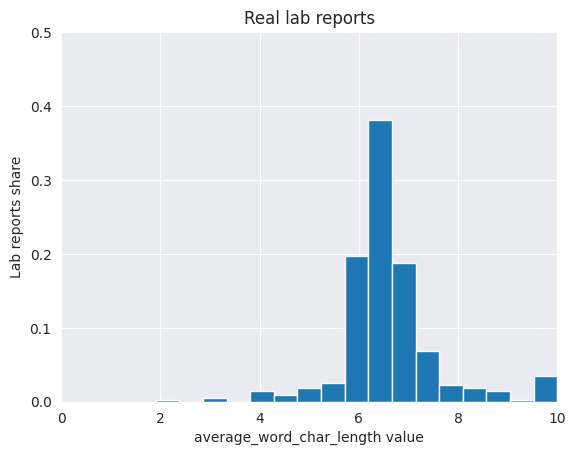

In [31]:
compare_2_hists('average_word_char_length', min_value=0, max_value=10, top=0.5)

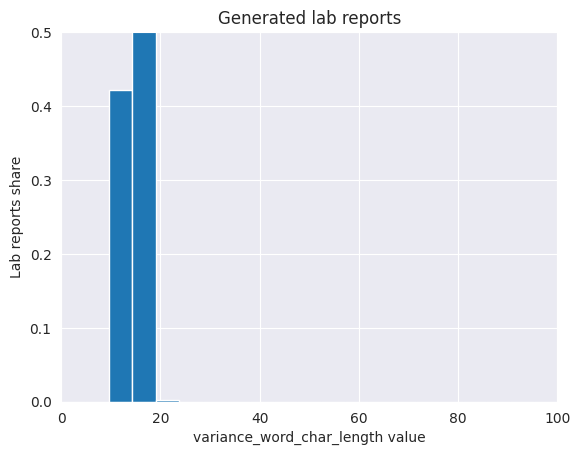

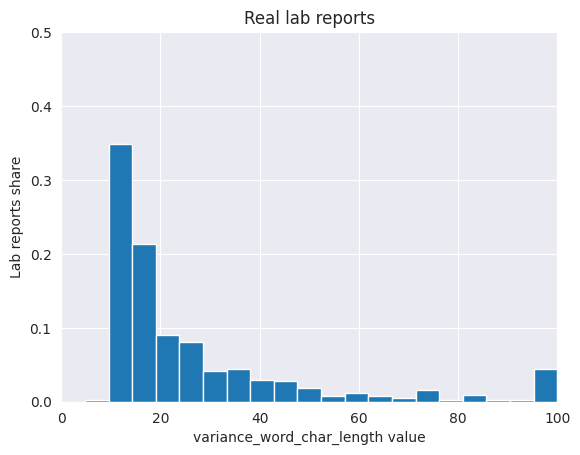

In [35]:
compare_2_hists('variance_word_char_length', min_value=0, max_value=100, top=0.5)

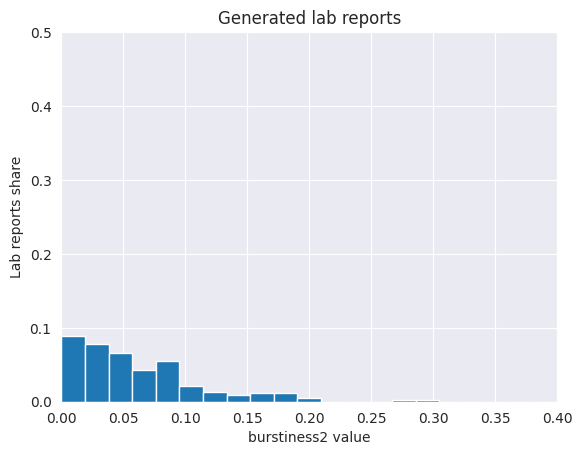

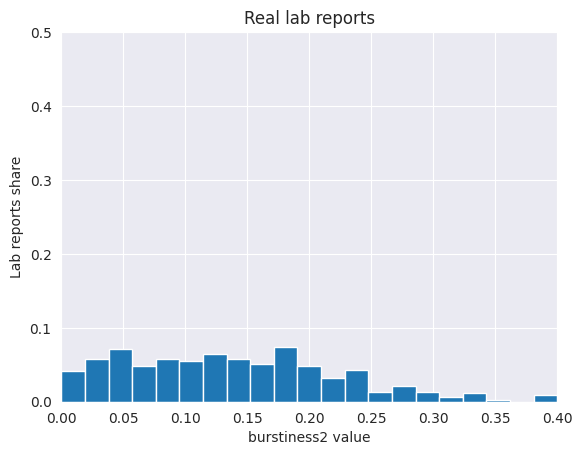

In [38]:
compare_2_hists('burstiness2', min_value=0, max_value=0.4, top=0.5)